In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack
import pickle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
from scipy import stats
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter

Import data, set labels for classification:

In [2]:
path_data = "C:/Users/SG/hlca_core.h5ad"
adata = anndata.read_h5ad(path_data, backed = 'r')
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
cell_type_labels = adata.obs['ann_level_4'].astype(str)
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(set(cell_type_labels))

### Create training set where CD4s are fixed

Determine proportion of CD4s needed:

In [3]:
with open('Analysis_results/proportion_dictionary.pickle', 'rb') as file:
    full_dict = pickle.load(file)
    training_counts_dict = full_dict["training_sets"]

with open('color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

In [4]:
totals = []
for prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    counts = training_counts_dict["ann_4"][f'prop_{prop}']['CD4 T cells']
    totals.append(counts[0] + counts[1])
print(totals)

[4840, 5353, 5884, 6338, 6839, 7326, 7807, 8352, 8815, 9268, 9673]


In [5]:
# with equalized test sets!
def modified_train_clf_and_predict(X, y, sex_labels, proportion_female, classifier='knn', k = 30):
    '''
    This is a modification of the train_clf_and_predict_equaltest function that does not actually train/predict anything;
    it only selects the training set according to proportion_female and returns it.
    We fix the CD4 sub-population in the training set by calling fixed_select_indices_by_proportion separately on CD4 and non-CD4 samples.
    ----------
    
    Parameters:
    X = expression matrix; matrix of shape n_obs x n_vars
    y = (cell type) labels; array/list of shape n_obs
    sex_labels = 'male' or 'female' label for each entry; array/list of shape n_obs
    proportion_female = desired proportion of female cells; float between 0 and 1
    classifier = 'knn', 'svm' or 'rf'
    k = value if using knn; default 30
    ----------
    
    Returns:
    X_selected, y_selected, train_sex = entries, labels and sex labels for the selected training set 
    
    '''
    
    np.random.seed(83)
    
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]
    

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=83)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = X_female_test.shape[0] / X_male.shape[0]

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=83)
    

    # merge training sets back together
    # X_train = np.concatenate([X_male_train, X_female_train])
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]


    # Select female cells based on proportion_female

    # extract CD4s
    cd4_mask = (y_train == 'CD4 T cells')
    non_cd4_mask = ~cd4_mask

    # call fixed_select_indices_by_proportion on the CD4 and non-CD4 samples separately 
    selected_non_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(non_cd4_mask)[0]], proportion_female)
    selected_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(cd4_mask)[0]], proportion_female)
    # the stitch them together
    selected_indices = np.concatenate((np.where(non_cd4_mask)[0][selected_non_cd4_indices], np.where(cd4_mask)[0][selected_cd4_indices]))
    
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(83)
    sex_labels_series = pd.Series( (el for el in sex_labels))    
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

We will use the same function as when we determined training set proportions previously:

In [6]:
def plot_distribution(label_lists, sex_label_lists, title, colors):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    plt.show()

    # return values
    return label_dict


In [7]:
label_lists = []
sex_label_lists = []
for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex = modified_train_clf_and_predict(embedding, cell_type_labels, sex_labels, prop)
    label_lists.append(y_selected)
    sex_label_lists.append(train_sex)

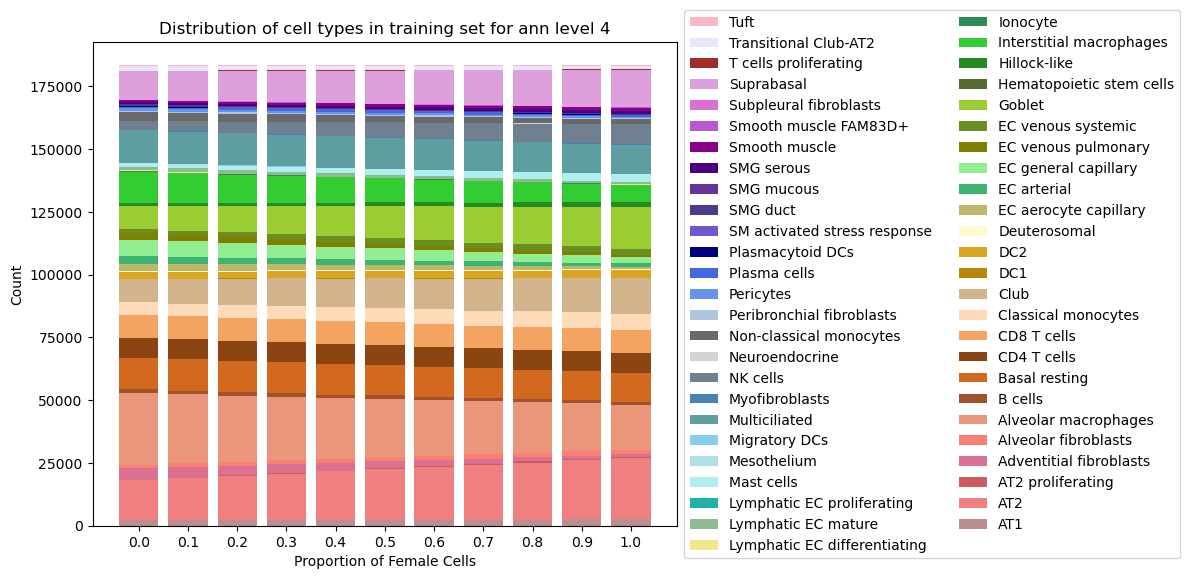

In [8]:
count_dict = plot_distribution(label_lists, sex_label_lists, "Distribution of cell types in training set for ann level 4", list(color_mappings["ann_4"].values()))

Check that CD4 counts remain fixed:

In [9]:
totals = []
for prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    counts = count_dict[f'prop_{prop}']['CD4 T cells']
    totals.append(counts[0] + counts[1])
print(totals)

[7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992]


Check that overall sex proportions in the training set are still as specified:

In [10]:
for arr in sex_label_lists:
    print(np.round(np.count_nonzero(arr == 'female')/len(arr),1))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


### Classification experiment

This is run using scripts, on a cluster. The script template and helper function file are given in the classification_templates folder. The helper function file is the same as for previous classification experiments, but contains the separate selection for CD4 cells as defined above.

#### Check that overall classification trend has not changed

In [11]:
general_path = "Classification_results/cd4_fixing"
proportions = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [12]:
def gather_data(general_path):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # KNN
    metrics_knn = {'male': {}, 'female': {}}
        
    for key in metrics_knn.keys():
        metrics_knn[key] = {
            'accuracy': [],
            'median_f1': [],
            'mean_f1_per_class': [],
            'median_precision': [],
            'mean_prec_per_class': []
            }
    
    # read the file:
    male_lst = []
    female_lst = []
    for p in ['0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1']:
        male_file_path = f'{general_path}/{p}_male_metrics.pickle'
        female_file_path = f'{general_path}/{p}_female_metrics.pickle'
    
        with open(male_file_path, 'rb') as file:
            male_results = pickle.load(file)
        with open(female_file_path, 'rb') as file:
            female_results = pickle.load(file)
        male_lst.append(male_results)
        female_lst.append(female_results)

    # put them all together
    for i in range(len(male_lst)):
            male_result = male_lst[i]
            female_result = female_lst[i]
        
            metrics_knn['male']['accuracy'].append(male_result['accuracy'] if 'accuracy' in male_result.keys() else np.nan)
            metrics_knn['male']['median_f1'].append(male_result['median_f1']  if 'median_f1' in male_result.keys() else np.nan)
            metrics_knn['male']['median_precision'].append(male_result['median_precision']  if 'median_precision' in male_result.keys() else np.nan)
            metrics_knn['male']['mean_f1_per_class'].append(male_result['f1_scores']  if 'f1_scores' in male_result.keys() else [np.nan]*10)
            metrics_knn['male']['mean_prec_per_class'].append(male_result['precision_scores']  if 'precision_scores' in male_result.keys() else [np.nan]*10)
            
        
            metrics_knn['female']['accuracy'].append(female_result['accuracy'] if 'accuracy' in female_result.keys() else np.nan)
            metrics_knn['female']['median_f1'].append(female_result['median_f1']  if 'median_f1' in female_result.keys() else np.nan)
            metrics_knn['female']['median_precision'].append(female_result['median_precision']  if 'median_precision' in female_result.keys() else np.nan)
            metrics_knn['female']['mean_f1_per_class'].append(female_result['f1_scores']  if 'f1_scores' in female_result.keys() else [np.nan]*10)
            metrics_knn['female']['mean_prec_per_class'].append(female_result['precision_scores']  if 'precision_scores' in female_result.keys() else [np.nan]*10)

    return metrics_knn

In [13]:
# modify gather_accuracies_ann_level, plot_accuracy and plot_f1_boxplot functions to take just one seed

def plot_accuracy(proportions, general_path):
    plt.figure(figsize=(10, 5))

    metrics_knn = gather_data(general_path)
    plt.plot(proportions, metrics_knn['male']['accuracy'], color='brown', label='Male test set', lw = 1)
    plt.plot(proportions, metrics_knn['female']['accuracy'], color='orange', label='Female test set', lw = 1)
    plt.legend(loc = 'lower left')
    
    plt.grid()
    plt.xlabel('% female samples')
    plt.ylabel('Accuracy scores')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.show()


def gather_f1scores(proportions, general_path):
    data_knn = []

    metrics_knn = gather_data(general_path)

    for index, prop in enumerate(proportions):
        for class_index, f1_score in enumerate(metrics_knn['male']['mean_f1_per_class'][index]):
            data_knn.append({
                'proportion': prop,
                'sex': 'male',
                'class_index': class_index,
                'F1_score': f1_score
            })
        for class_index, f1_score in enumerate(metrics_knn['female']['mean_f1_per_class'][index]):
             data_knn.append({
                 'proportion': prop,
                 'sex': 'female',
                 'class_index': class_index,
                 'F1_score': f1_score
                })

    return pd.DataFrame(data_knn)


def plot_f1_boxplot(proportions, general_path, stat = 't-test', outliers = False):
    data = gather_f1scores(proportions, general_path)

    plt.figure(figsize=(20, 5))

    male_data = data[data['sex'] == 'male'].copy()
    female_data = data[data['sex'] == 'female'].copy()

    positions = range(1, len(proportions) + 1)
    # compute median per class
    f1_medians_male = male_data.groupby(['proportion', 'class_index']).median(numeric_only=True).reset_index()
    f1_medians_female = female_data.groupby(['proportion', 'class_index']).median(numeric_only=True).reset_index()
    # format for plotting
    f1_scores_male = [f1_medians_male[f1_medians_male['proportion'] == prop]['F1_score'].tolist() for prop in proportions]
    f1_scores_female = [f1_medians_female[f1_medians_female['proportion'] == prop]['F1_score'].tolist() for prop in proportions]

    # plot
    bplot1 = plt.boxplot(f1_scores_male, positions=[pos - 0.2 for pos in positions], showfliers=outliers, widths=0.25, patch_artist=True, labels=['male']*len(proportions))
    bplot2 = plt.boxplot(f1_scores_female, positions=[pos + 0.2 for pos in positions], showfliers=outliers, widths=0.25, patch_artist=True, labels=['female']*len(proportions))

    # customize boxplots - fill with colors
    color_label1 = 'steelblue'
    color_label2 = 'lightsalmon'

    for patch, color in zip(bplot1['boxes'], [color_label1] * len(bplot1['boxes'])):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for patch, color in zip(bplot2['boxes'], [color_label2] * len(bplot2['boxes'])):
        patch.set_facecolor(color)
        patch.set_alpha(0.9)

    # customize median lines
    for median_line in bplot1['medians']:
        median_line.set_color('powderblue')
        median_line.set_linewidth(2)

    for median_line in bplot2['medians']:
        median_line.set_color('maroon')
        median_line.set_linewidth(2)

    # create legend
    legend_patch1 = mpatches.Patch(color=color_label1, label='male')
    legend_patch2 = mpatches.Patch(color=color_label2, label='female')
    plt.legend(handles=[legend_patch1, legend_patch2])

    # perform significance testing
    for i, prop in enumerate(proportions):
        male_scores = f1_medians_male[f1_medians_male['proportion'] == prop]['F1_score']
        female_scores = f1_medians_female[f1_medians_female['proportion'] == prop]['F1_score']
        if stat == 't-test':
            _, p_value = stats.ttest_rel(female_scores, male_scores)
        else:
            _, p_value = stats.mannwhitneyu(female_scores, male_scores, alternative='two-sided')

        print(f"{prop} -> {p_value}")
        if p_value < 0.05:
            significance = "*"
        else:
            significance = ""
        
        if significance:
            # we need to get the non-outlier values to see where to place the annotation
            lower_y = min([item.get_ydata().min() for item in bplot1['whiskers'][2*i:2*i+2] + bplot2['whiskers'][2*i:2*i+2]])
            bracket_y, h, col = lower_y - 0.02, 0.01, 'k'
            plt.plot([i + 1 - 0.2, i + 1 - 0.2, i + 1 + 0.2, i + 1 + 0.2], [bracket_y, bracket_y - h, bracket_y - h, bracket_y], lw=1.5, c=col)
            plt.text(i + 1, bracket_y - 3 * h, significance, ha='center', va='bottom', color=col, fontsize=12)

    plt.xlabel('Proportions')
    plt.ylabel('F1 Score')
    plt.xticks(positions, proportions)
    plt.grid(True)

    plt.show()

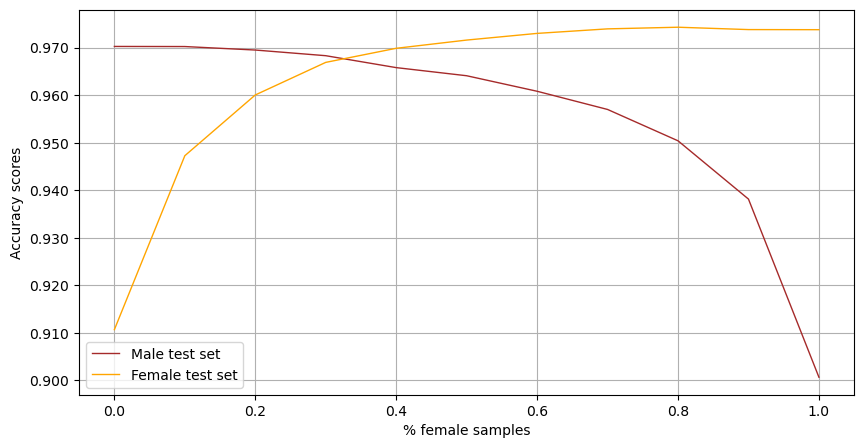

In [14]:
plot_accuracy(proportions, general_path)

0 -> 0.0013938663719278586
0.1 -> 0.2166191272754647
0.2 -> 0.17023239644453855
0.3 -> 0.663331551546647
0.4 -> 0.7304222853382492
0.5 -> 0.9415302240382645
0.6 -> 0.698122589818075
0.7 -> 0.6480844186620596
0.8 -> 0.12278850020919505
0.9 -> 0.17663818373223084
1 -> 3.8046613574958472e-06


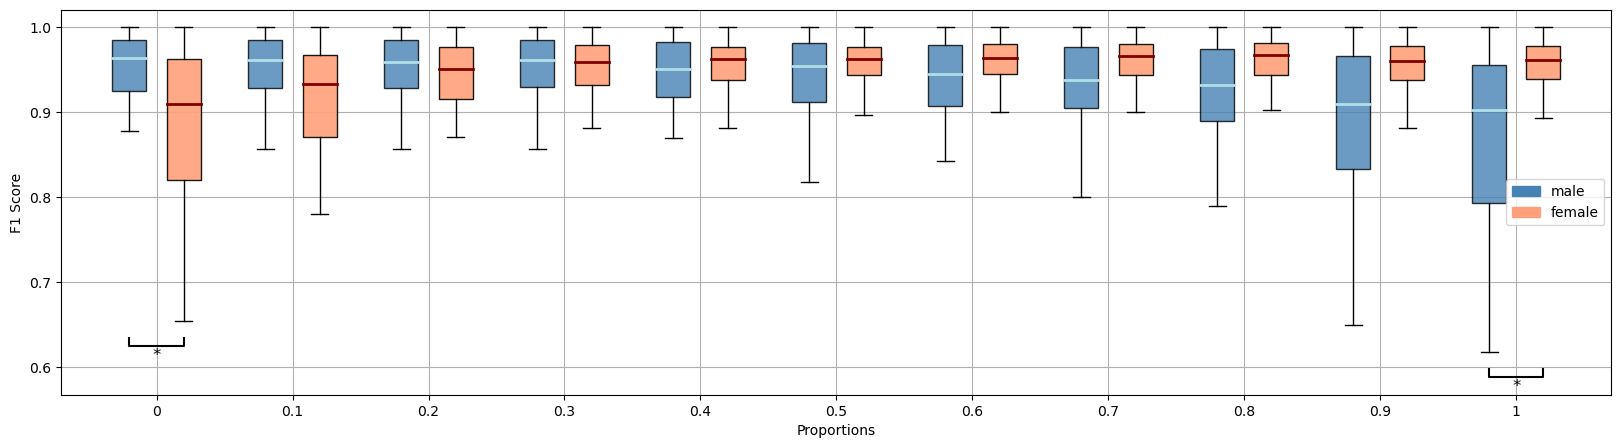

In [15]:
plot_f1_boxplot(proportions, general_path)

#### Classification pattern for CD4 T-cells

In [16]:
with open('cell_names.pickle', 'rb') as file:
    cell_names_dict = pickle.load(file)
cell_names = cell_names_dict['ann_4']

results_df = pd.DataFrame(columns=['Cell type', 'Slope test', 'Flip test'])

In [17]:
def gather_cms(general_path, cell_names, cell_type):    
    male_lst = []
    female_lst = []
    
    text_proportions = ['0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1']
    for p in text_proportions:
        male_file_path = f'{general_path}/{p}_male_metrics.pickle'
        female_file_path = f'{general_path}/{p}_female_metrics.pickle'
    
        with open(male_file_path, 'rb') as file:
            male_results = pickle.load(file)
        with open(female_file_path, 'rb') as file:
            female_results = pickle.load(file)
    
        male_lst.append(pd.DataFrame(male_results['normalized_aggregated_confusion_matrix'], columns=cell_names, index=cell_names))
        female_lst.append(pd.DataFrame(female_results['normalized_aggregated_confusion_matrix'], columns=cell_names, index=cell_names))

    return male_lst, female_lst

def misclassified_as(cell_type, lst):
    res = set()

    for df in lst:
        row = df.loc[cell_type]
        cols = row[row>0].index.to_list()
        if cell_type in cols:
            cols.remove(cell_type)
        res.update(cols)
    
    return res

def compute_difference(arr1, arr2):
    max_diff = float('-inf')
    
    for i in range(len(arr1)):
        diff = abs(arr1[i] - arr2[i])
        if diff > max_diff:
            max_diff = diff
    return max_diff

def plot_diff_classif(cell_type, classified, female_lst, male_lst, cell_counts_dict, title = None):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    plt.figure(figsize=(11,6))
    
    female_performance = [female_lst[prop].loc[cell_type,classified] for prop in range(len(proportions))]
    male_performance = [male_lst[prop].loc[cell_type,classified] for prop in range(len(proportions))]

    max_diff = compute_difference(female_performance, male_performance)

    
    plt.plot(proportions, female_performance, color = 'brown', label = 'Female test set')
    plt.plot(proportions, male_performance, color = 'darkblue', label = 'Male test set')
    plt.xlabel('% of female cells in training set', fontsize = 12)
    plt.ylabel(f'% of correctly classified {cell_type}', fontsize = 12)
    plt.legend(bbox_to_anchor=(1.26, 0.6), fontsize = 12)
    plt.xticks(proportions, fontsize = 12)
    yticks = plt.gca().get_yticks()
    plt.yticks(yticks, fontsize=12)

    current_ylim = plt.gca().get_ylim()
    plt.ylim(max(current_ylim[0], 0), min(current_ylim[1], 1))

    if title:
        plt.title(f'{cell_type} as {classified} {title}', fontsize = 14)
    else:
        plt.title(f'{cell_type} as {classified}', fontsize = 14)
    plt.show()

    # check performance trend:
    slope_female = check_slope(female_performance, proportions)
    slope_male = check_slope(male_performance, proportions)

    # check flipping of performance:
    flip = (female_performance[0] - male_performance[0])*(female_performance[-1] - male_performance[-1])
        # if flip < 0: a flip has occured
        # if flip > 0: female performance is better/worse than the male performance at both ends of the spectrum

    return (slope_female, slope_male), (slope_female * slope_male < 0, flip < 0), max_diff

def plot_heatmap(cell_counts_dict, cell_type):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    data = []
    
    for prop in proportions:
        counts = cell_counts_dict[f"prop_{prop}"].get(cell_type, (0, 0))
        total = counts[0] + counts[1]
        data.append([total, counts[0], counts[1]])

    heatmap_data = np.array(data).T

    fig, ax = plt.subplots(figsize=(14, 3))
    
    # modified color map because full one looks bad with black text
    cmap = plt.get_cmap('YlGn', 256)  
    new_cmap = cmap(np.linspace(0, 0.85, 256))  # avoid darkest green
    cax = ax.matshow(heatmap_data, cmap=plt.cm.colors.ListedColormap(new_cmap))
    #cax = ax.matshow(heatmap_data, cmap='YlGn')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(proportions)))
    ax.set_xticklabels(proportions, fontsize = 12)
    ax.set_yticks(np.arange(3))
    ax.set_yticklabels(['Total', 'Male', 'Female'], fontsize = 12)

    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            ax.text(j, i, str(heatmap_data[i, j]), va='center', ha='center')

    ax.set_xlabel('% of female cells in training set', fontsize = 12)
    plt.title(f'Training Set Counts for {cell_type}', fontsize = 13)
    plt.show()

def plot_combined_classif(cell_type, female_lst, male_lst, color_dict):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    misclassified = misclassified_as(cell_type, male_lst + female_lst)
    if not misclassified:
        print(f"No misclassifications for {cell_type}. Skipping plot.")
        return

    fig, axs = plt.subplots(1, 2, figsize=(11, 6))
    
    for classified in misclassified:
        color = color_dict.get(classified)
                               
        female_data = [female_lst[prop].loc[cell_type,classified] for prop in range(len(proportions))]
        male_data = [male_lst[prop].loc[cell_type,classified] for prop in range(len(proportions))]
        
        axs[0].plot(proportions, female_data, label=classified, color = color) # female plot
        axs[1].plot(proportions, male_data, label=classified, color = color) # male plot

    axs[0].set_title(f'Female test set', fontsize = 11)
    axs[0].set_xlabel('% of female cells in training set', fontsize = 11)
    axs[0].set_ylabel('% of predicted instances', fontsize = 11)
    
    axs[1].set_title(f'Male test set', fontsize = 11)
    axs[1].set_xlabel('% of female cells in training Set', fontsize = 11)

    handles, labels = axs[0].get_legend_handles_labels()
    if len(handles) > 18:
        height, cols, y_title = 0.97, 7, 0.99
    elif len(handles) > 15:
        height, cols, y_title = 0.95, 6, 0.97
    elif len(handles) > 12:
        height, cols, y_title = 0.97, 5, 1
    elif len(handles) > 9:
        height, cols, y_title = 0.96, 4, 0.98
    elif len(handles) > 6:
        height, cols, y_title = 0.97, 3, 0.99
    elif len(handles) > 3:
        height, cols, y_title = 0.93, 3, 0.95
    else:
        height, cols, y_title = 0.90, 3, 0.93
        
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, height), ncol=cols)
    fig.suptitle(f'Cell types misclassified as {cell_type}', y = y_title, fontsize = 13)

    plt.subplots_adjust(top=0.8)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()
    
def check_slope(performance_values, proportions):
    model = LinearRegression().fit(np.reshape(proportions, (-1, 1)), np.reshape(performance_values, (-1, 1)))
    slope = model.coef_[0][0]
    return slope

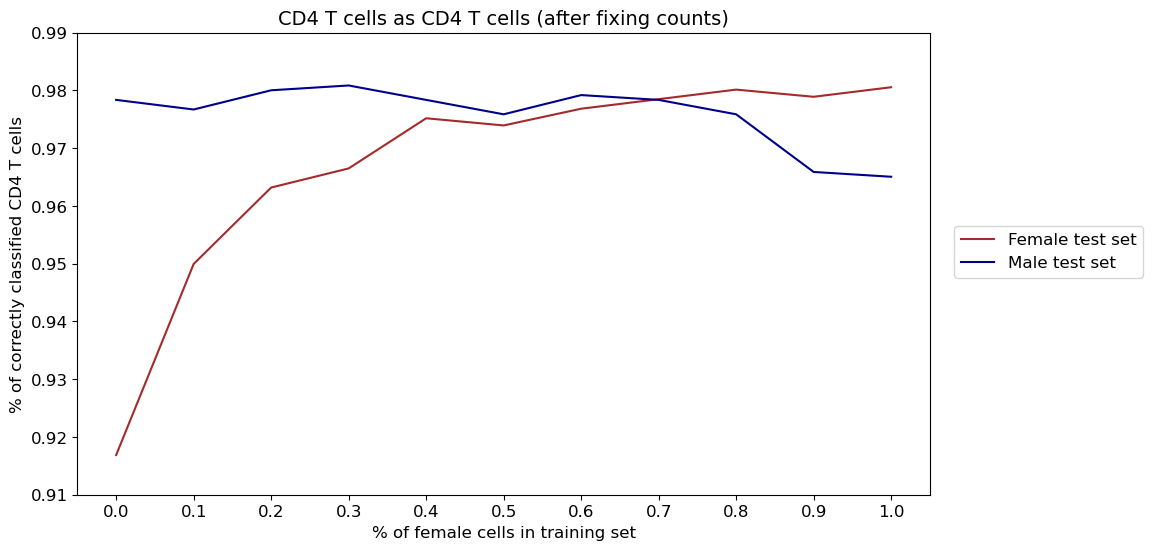

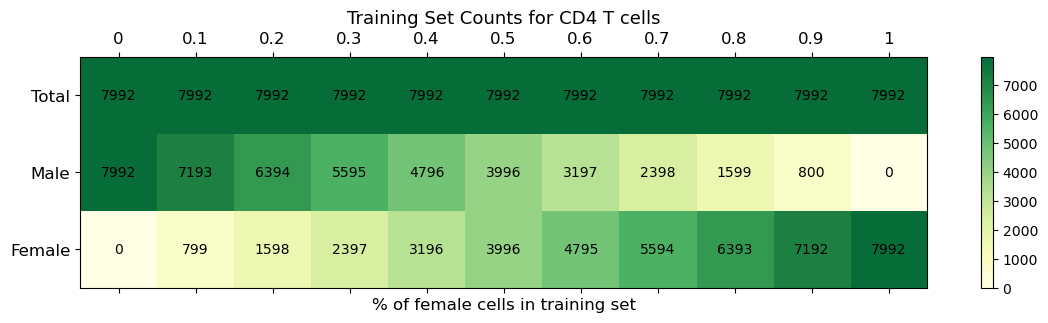

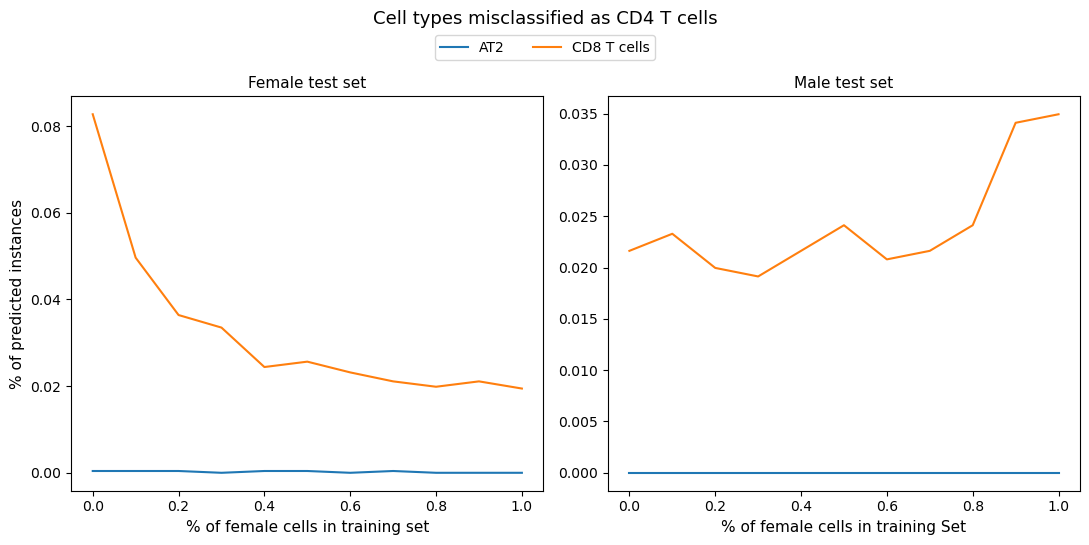

In [18]:
cell_type = 'CD4 T cells'
male_lst, female_lst = gather_cms(general_path, cell_names, cell_type)
slopes, opposing_tuple, max_diff = plot_diff_classif(cell_type, cell_type, female_lst, male_lst, count_dict, title = '(after fixing counts)')
plot_heatmap(count_dict, cell_type)
plot_combined_classif(cell_type, female_lst, male_lst,  color_dict = color_mappings)

temp_df = pd.DataFrame({
    'Cell type': [cell_type],
    'Slope test': [opposing_tuple[0]],
    'Flip test': [opposing_tuple[1]],
    'Maximum performance difference': [max_diff],
    'Slope on female set': slopes[0],
    'Slope on male set': slopes[1]
})
results_df = pd.concat([results_df, temp_df], ignore_index=True)

In [19]:
results_df

,Cell type,Slope test,Flip test,Maximum performance difference,Slope on female set,Slope on male set
0,CD4 T cells,True,True,0.061496,0.046432,-0.011496


In [20]:
# consider 'distinct behavior' if both slope test and flip test are fulfilled:
results_df['Misclassification trend'] = results_df.apply(
    lambda row: 'Distinct' if row['Slope test'] and row['Flip test'] else 'Non-distinct',
    axis=1
)

results_df.loc[:, 'Slope on male set'] = round(results_df.loc[:, 'Slope on male set'], 3)
results_df.loc[:, 'Slope on female set'] = round(results_df.loc[:, 'Slope on female set'], 3)
results_df.loc[:, 'Maximum performance difference'] = round(results_df.loc[:, 'Maximum performance difference'], 3)

results_df.loc[:,["Cell type", "Slope on male set", "Slope on female set", "Slope test", "Flip test", "Maximum performance difference", "Misclassification trend"]]

,Cell type,Slope on male set,Slope on female set,Slope test,Flip test,Maximum performance difference,Misclassification trend
0,CD4 T cells,-0.011,0.046,True,True,0.061,Distinct
